In [1]:
import calendar
import datetime as dt
import dateutil.parser as dp
import gspread
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os

from IPython.display import display
from functools import partial
from oauth2client.service_account import ServiceAccountCredentials

# Setting up key, token and Service Account

In [2]:
with open('keys.json') as file:
    keys = json.load(file)
    api_key = keys['trello']['api_key']
    token = keys['trello']['token']
    spreadsheet_key = keys['sheet']['spreadsheet_key']
    sa_file = keys['sheet']['sa_file']

# Extracting Sheet Data

In [3]:
def convert_sheet_date(sheet_date):
    conversion_table = {
        'January': '01',
        'February': '02',
        'March': '03',
        'April': '04',
        'May': '05',
        'June': '06',
        'July': '07',
        'August': '08',
        'September': '09',
        'October': '10',
        'November': '11',
        'December': '12'
    }
    
    month = conversion_table[sheet_date.split('-')[0].strip()]
    year = sheet_date.split('-')[1].strip()
    
    return year + '-' + month

In [4]:
def get_consolidated_sheet():
    scope = ['https://spreadsheets.google.com/feeds']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(sa_file, scope) 
    gc = gspread.authorize(credentials)
    
    book = gc.open_by_key(spreadsheet_key)
    worksheet = book.worksheet("Consolidated")
    table = worksheet.get_all_values()
    
    return table

In [5]:
def get_total_by_date():
    table = get_consolidated_sheet()
    
    header_row = table[0]
    columns = [value for index, value in enumerate(header_row) if value] 
    converted_columns = [ convert_sheet_date(x) for x in columns[1:]]
    
    total_row = table[16]
    # getting only the executed column
    total = [value for index, value in enumerate(total_row) if index % 3 == 0]
    total.pop(0)
    
    total_by_date = [ [converted_columns[index], value] for index, value in enumerate(total)]
    
    return total_by_date

In [6]:
def create_ftes_dataframe():
    # from deprecated sheet, it will never be changed
    old_data = [
        ['2020-03', 4.0],
        ['2020-04', 6.15],
        ['2020-05', 6.25],
        ['2020-06', 6.0],
        ['2020-07', 3.65],
        ['2020-08', 4.57],
        ['2020-09', 4.52],
        ['2020-10', 4.9],
        ['2020-11', 4.7]
    ]
    
    new_data = get_total_by_date()
    
    full_data = old_data + new_data
    
    total_fte = pd.DataFrame(full_data, columns=['month_base', 'fte'])
    
    total_fte['month_base'] = pd.to_datetime(total_fte['month_base'])
    total_fte['month'] = pd.PeriodIndex(total_fte['month_base'], freq='M')
    total_fte['quarter'] = pd.PeriodIndex(total_fte['month_base'], freq='Q')
    total_fte['fte'] = total_fte['fte'].astype(float)
    
    del total_fte['month_base']
    
    return total_fte

In [7]:
total_fte = create_ftes_dataframe()

In [8]:
total_fte

,fte,month,quarter
0,4.00,2020-03,2020Q1
1,6.15,2020-04,2020Q2
2,6.25,2020-05,2020Q2
3,6.00,2020-06,2020Q2
4,3.65,2020-07,2020Q3
5,4.57,2020-08,2020Q3
6,4.52,2020-09,2020Q3
7,4.90,2020-10,2020Q4
8,4.70,2020-11,2020Q4
9,4.90,2020-12,2020Q4


# Extracting Trello Data

In [9]:
def get_data_from_trello_api(url):
    headers = {
       "Accept": "application/json"
    }
    
    query = {
       'key': api_key,
       'token': token
    }
    
    response = requests.request("GET", url, headers=headers, params=query)
    
    if response.status_code > 299:
        raise Exception('Something went wrong with the request {0} '\
                        'with status: {1}'.format(url, response.status_code))
    
    return json.loads(response.text)

In [10]:
def read_json(json_name):
    with open(json_name) as file:
        json_opened = json.load(file)
           
    return json_opened 

In [11]:
def write_json(json_name, content_to_write):
    with open(json_name, 'w') as json_file:
        json.dump(content_to_write, json_file, indent=4, sort_keys=True)

In [12]:
def generate_timestamp():
    current_timestamp = dt.datetime.now().strftime('%d-%m-%Y')
    
    return current_timestamp

In [13]:
def create_folder_for_dumping(name, current_timestamp):
    if not os.path.exists('dumps'):
        os.mkdir('dumps')
    
    if not os.path.exists('dumps/' + name):
        os.mkdir('dumps/' + name)
    
    if not os.path.exists('dumps/' + name + '/' + current_timestamp):
        os.mkdir('dumps/' + name + '/' + current_timestamp)

In [14]:
def get_data_from_dump(board_name, dump_name, timestamp):
    path = 'dumps/' + board_name + '/' + timestamp + '/dump_' + dump_name + '.json'
    
    file_opened = read_json(path)
    
    return file_opened

# Acessing API

In [15]:
def get_board_by_name(board_name):
    boards_url = f'https://api.trello.com/1/search?query={board_name}'
    board = get_data_from_trello_api(boards_url)
    
    return board

In [16]:
def get_lists_by_board(board_name, board_id, current_timestamp):
    lists_url = 'https://api.trello.com/1/boards/{0}/lists'
    lists = get_data_from_trello_api(lists_url.format(board_id))
          
    return lists

In [17]:
def get_custom_fields_by_board(board_name, board_id, current_timestamp):
    custom_fields_url = 'https://api.trello.com/1/boards/{0}/customFields'
    
    custom_fields = get_data_from_trello_api(custom_fields_url.format(board_id))
    
    return custom_fields

In [18]:
def get_cards_by_board(board_name, board_id, current_timestamp):
    cards_on_board_url = 'https://api.trello.com/1/boards/{0}/cards/?customFieldItems=true'
    board_cards = get_data_from_trello_api(cards_on_board_url.format(board_id))
    
    return board_cards

# Creating dumps

In [19]:
def create_boards_dump(board_name, current_timestamp):
    boards = get_board_by_name(board_name)

    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_board.json'
        
    write_json(name_of_dump, boards)
    
    return name_of_dump

In [20]:
def get_id_board_from_dump(board_name, current_timestamp):
    board = get_board_by_name_from_dump(board_name, current_timestamp)
    id_board = board['boards'][0]['id']

    return id_board

In [21]:
def create_lists_dump(board_name, board_id, current_timestamp):
    lists = get_lists_by_board(board_name, board_id, current_timestamp)
    
    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_lists.json'
    write_json(name_of_dump, lists)
        
    return name_of_dump

In [22]:
def create_custom_fields_dump(board_name, board_id, current_timestamp):
    custom_fields = get_custom_fields_by_board(board_name, board_id, current_timestamp)
        
    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_custom_field.json'
    write_json(name_of_dump, custom_fields)
        
    return name_of_dump

In [23]:
def create_cards_dump(board_name, board_id, current_timestamp):
    board_cards = get_cards_by_board(board_name, board_id, current_timestamp)    
       
    name_of_dump = f'dumps/{board_name}/{current_timestamp}/dump_cards.json'
    
    write_json(name_of_dump, board_cards)
            
    return name_of_dump

In [24]:
def create_dumps_by_name(board_name, current_timestamp):
    create_folder_for_dumping(board_name, current_timestamp)
    
    create_boards_dump(board_name, current_timestamp)
    
    board_id = get_id_board_from_dump(board_name, current_timestamp)
    
    create_lists_dump(board_name, board_id, current_timestamp)
    create_custom_fields_dump(board_name, board_id, current_timestamp)
    create_cards_dump(board_name, board_id, current_timestamp)

# Getting data from dumps

In [25]:
def get_board_by_name_from_dump(board_name, timestamp):
    board = get_data_from_dump(board_name, 'board', timestamp)
    
    return board

In [26]:
def mapping_lists_by_board_from_dump(board_name, timestamp):
    lists_json = get_data_from_dump(board_name, 'lists', timestamp)
    
    list_map = {}
    for list in lists_json:
        list_map[list['id']] = list['name']
    
    return list_map

In [27]:
def mapping_custom_fields_by_board_from_dump(board_name, timestamp):
    custom_fields_json = get_data_from_dump(board_name, 'custom_field', timestamp)
    
    custom_field_map = {}
    for custom_field in custom_fields_json:
        custom_field_map[custom_field['id']] = custom_field['name']
    
    return custom_field_map

In [28]:
def get_useful_cards_by_board(board_name, timestamp):
    cards_raw = get_data_from_dump(board_name, 'cards' , timestamp)
        
    fields = ('id', 'name', 'idList', 'shortUrl', 'customFieldItems')

    cards = [{key : value for key, value in card.items() if key in fields} for card in cards_raw ]

    custom_fields_map = mapping_custom_fields_by_board_from_dump(board_name, timestamp)

    lists_map = mapping_lists_by_board_from_dump(board_name, timestamp)

    useful_cards = []
    for card in cards:
        idListName = lists_map[card['idList']]
        if idListName in ['Done']:
            normalized_card = {}

            for custom_field in card['customFieldItems']:
                name = custom_fields_map[custom_field['idCustomField']]
                if name in ['Start', 'End', 'EndDev']:
                    value = custom_field['value']['date']
                    normalized_card[name] = value

            if len(normalized_card) < 3:
                raise Exception(
                    'Make sure all dates are filled in the card: Start, EndDev and End for {0}'.format(card['name']))

            normalized_card['name'] = card['name']
            normalized_card['shortUrl'] = card['shortUrl']
            normalized_card['idList'] = lists_map[card['idList']]
            useful_cards.append(normalized_card)
    
    
    
    return useful_cards

In [29]:
def create_dataframe_from_trello(board_name, timestamp):
    cards = get_useful_cards_by_board(board_name, timestamp)
    df = pd.DataFrame.from_dict(cards)

    df['dev_duration'] = (pd.to_datetime(df['EndDev']).dt.date - pd.to_datetime(df['Start']).dt.date).dt.days
    df['duration'] = (pd.to_datetime(df['End']).dt.date - pd.to_datetime(df['Start']).dt.date).dt.days
    
    df['busday_dev_duration'] = np.busday_count(
        pd.to_datetime(df['Start']).dt.date,
        pd.to_datetime(df['EndDev']).dt.date)
    
    df['busday_duration'] = np.busday_count(
        pd.to_datetime(df['Start']).dt.date,
        pd.to_datetime(df['End']).dt.date)
    
    df['quarter'] = pd.PeriodIndex(df['End'], freq='Q')
    
    df['month'] = pd.PeriodIndex(df['End'], freq='M')

    df["count"] = 1
    
    return df

In [30]:
pd.set_option('display.max_rows', None)

current_timestamp = generate_timestamp()
create_dumps_by_name('CBN', current_timestamp)
df = create_dataframe_from_trello('CBN', current_timestamp)

In [31]:
df

,EndDev,End,Start,name,shortUrl,idList,dev_duration,duration,busday_dev_duration,busday_duration,quarter,month,count
0,2021-06-08T23:38:18.000Z,2021-06-22T00:37:41.000Z,2021-05-20T18:20:45.000Z,GCP_SECURITYCENTER,https://trello.com/c/Ihn57c3z,Done,19,33,13,23,2021Q2,2021-06,1
1,2021-06-14T21:02:47.000Z,2021-06-21T23:29:16.000Z,2021-05-31T18:05:26.000Z,ASOC_ALERT,https://trello.com/c/6oORBYTM,Done,14,21,10,15,2021Q2,2021-06,1
2,2021-05-25T22:00:49.000Z,2021-06-16T22:34:09.000Z,2021-04-29T18:23:55.000Z,PROOFPOINT_ON_DEMAND,https://trello.com/c/EnS72vFi,Done,26,48,18,34,2021Q2,2021-06,1
3,2021-06-10T20:53:26.000Z,2021-06-14T13:54:24.000Z,2021-05-12T14:42:58.000Z,THINKST_CANARY(CBN default parser),https://trello.com/c/jk9h4ZMk,Done,29,33,21,23,2021Q2,2021-06,1
4,2021-05-28T17:45:42.000Z,2021-06-07T15:52:36.000Z,2021-05-25T11:43:32.000Z,MEDIGATE_IOT(new event types),https://trello.com/c/cP3D6FmY,Done,3,13,3,9,2021Q2,2021-06,1
5,2021-05-12T14:14:00.000Z,2021-06-07T14:47:12.000Z,2021-04-01T13:03:32.000Z,SAILPOINT_IAM,https://trello.com/c/OUkGPkAc,Done,41,67,29,47,2021Q2,2021-06,1
6,2021-05-31T17:41:02.000Z,2021-06-03T04:43:09.000Z,2021-05-26T20:29:59.000Z,GCP_DNS(vmInstanceIdString),https://trello.com/c/CXB0SnrT,Done,5,8,3,6,2021Q2,2021-06,1
7,2021-06-01T12:57:39.000Z,2021-06-01T15:44:22.000Z,2021-05-28T14:50:23.000Z,BRO_JSON(include namespace),https://trello.com/c/NST7PlFf,Done,4,4,2,2,2021Q2,2021-06,1
8,2021-05-27T13:23:40.000Z,2021-05-31T14:43:21.000Z,2021-05-18T11:36:29.000Z,UMBRELLA_WEBPROXY_b182561857,https://trello.com/c/iJzek0dV,Done,9,13,7,9,2021Q2,2021-05,1
9,2021-05-24T19:37:18.000Z,2021-05-26T19:25:48.000Z,2021-05-17T17:25:23.000Z,WINEVTLOG_b182559685,https://trello.com/c/BQMQuZUu,Done,7,9,5,7,2021Q2,2021-05,1


In [32]:
cancelled = df[(df['idList'] == 'Cancelled')]
done = df[(df['idList'] == 'Done')]

# Joining both fte and parsers tables

# Calculating General Estimatives

# Functions

In [33]:
def get_extremes(data_frame, duration_column):
    upper_q = partial(pd.Series.quantile, q=0.95)
    lower_q = partial(pd.Series.quantile, q=0.05)

    upper_extremes = data_frame[duration_column].agg([upper_q])["quantile"]
    lower_extremes = data_frame[duration_column].agg([lower_q])["quantile"]
    
    return lower_extremes, upper_extremes

In [34]:
def calculate_estimatives_by_duration_column(data_frame, duration_column, print_results=True):
    lower_extremes, upper_extremes = get_extremes(data_frame, duration_column)
    
    done_extremes_removed = data_frame[(data_frame[duration_column] > lower_extremes) & (data_frame[duration_column] < upper_extremes)]
    mean_removed_extremes = done_extremes_removed[duration_column].mean()
    
    small_q = partial(pd.Series.quantile, q=0.25)
    small_limit = done_extremes_removed[duration_column].agg([small_q])["quantile"]
    
    small_extremes_removed = done_extremes_removed[(done_extremes_removed[duration_column] <= small_limit)]
    not_small_extremes_removed = done_extremes_removed[(done_extremes_removed[duration_column] > small_limit)]
    
    mean_small_extremes_removed = small_extremes_removed[duration_column].mean()
    mean_not_small_extremes_removed = not_small_extremes_removed[duration_column].mean()
    
    total_developed = len(data_frame)
    
    if print_results:
        print('lower_extremes ->', lower_extremes)
        print('upper_extremes ->', upper_extremes)
        print('small limit ->', small_limit)
        print('Done estimate (with "extremes" removed) ->', mean_removed_extremes)
        print('Done estimate for "Small" ones ->', mean_small_extremes_removed)
        print('Done estimate for "Big" ones ->', mean_not_small_extremes_removed)
        print('Total_developed ->', total_developed)

    return done_extremes_removed
    
    

In [35]:
def calculate_estimatives(data_frame):
    print('Total Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'duration')
    print('\n')
    print('Total Dev Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'dev_duration')
    print('\n')
    print('##############')
    print('#BUSINESS DAY#')
    print('##############')
    print('\n')
    print('Business Day Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'busday_duration')
    print('\n')
    print('Business Day Dev Duration:')
    print('\n')
    calculate_estimatives_by_duration_column(data_frame, 'busday_dev_duration')
    

In [36]:
def generate_tables_and_charts(data_frame, duration_column, print_tables, plot_charts):
    df1 = data_frame[[duration_column, 'quarter']].groupby('quarter').mean()
    df2 = data_frame[['quarter', 'count']].groupby('quarter').sum('count')
    df3 = data_frame[['month', 'count']].groupby('month').sum('count')
    
    if print_tables:
        display(df1)
        display(df2)
        display(df3)
    
    if plot_charts:
        df1.plot()
        df2.plot()
        df3.plot()


In [37]:
def generate_tables_and_charts_by_duration_colum(data_frame, duration_column, remove_extremes):
    if remove_extremes:
        df_with_no_extremes = calculate_estimatives_by_duration_column(data_frame, duration_column, False)
        generate_tables_and_charts(df_with_no_extremes, duration_column, True, True)
    else:
        generate_tables_and_charts(data_frame, duration_column, True, True)
    

In [38]:
def generate_full_duration_table_and_chart(data_frame, period): # quarter or month
    new_df = data_frame[['dev_duration', 'duration', 'busday_dev_duration', 'busday_duration', period]]
    new_df = new_df.groupby(period).mean()
    display(new_df)
    new_df.plot()

# General Estimatives

In [39]:
calculate_estimatives(done)

Total Duration:


lower_extremes -> 1.0
upper_extremes -> 53.249999999999986
small limit -> 12.0
Done estimate (with "extremes" removed) -> 19.423076923076923
Done estimate for "Small" ones -> 7.666666666666667
Done estimate for "Big" ones -> 23.545454545454547
Total_developed -> 120


Total Dev Duration:


lower_extremes -> 0.0
upper_extremes -> 41.19999999999999
small limit -> 7.0
Done estimate (with "extremes" removed) -> 13.476635514018692
Done estimate for "Small" ones -> 4.225806451612903
Done estimate for "Big" ones -> 17.25
Total_developed -> 120


##############
#BUSINESS DAY#
##############


Business Day Duration:


lower_extremes -> 1.0
upper_extremes -> 37.249999999999986
small limit -> 9.0
Done estimate (with "extremes" removed) -> 13.980582524271844
Done estimate for "Small" ones -> 5.896551724137931
Done estimate for "Big" ones -> 17.14864864864865
Total_developed -> 120


Business Day Dev Duration:


lower_extremes -> 0.0
upper_extremes -> 29.14999999999999
small limit

# Duration time

In [40]:
df1 = df.copy()

,dev_duration,duration,busday_dev_duration,busday_duration
quarter,,,,
2020Q1,7.000000,12.500000,5.000000,9.500000
2020Q2,12.250000,16.666667,8.666667,11.916667
2020Q3,14.000000,16.428571,10.000000,11.761905
2020Q4,15.650000,22.550000,11.350000,16.250000
2021Q1,18.160000,25.720000,12.960000,18.360000
2021Q2,13.964286,20.071429,9.892857,14.142857


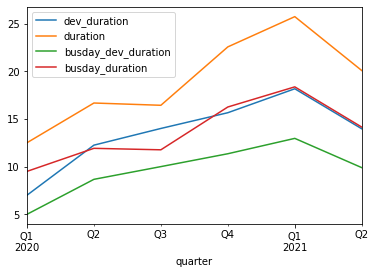

In [41]:
generate_full_duration_table_and_chart(df1, 'quarter')

,dev_duration,duration,busday_dev_duration,busday_duration
month,,,,
2020-03,7.000000,12.500000,5.000000,9.500000
2020-04,12.000000,19.666667,8.666667,14.333333
2020-05,17.666667,22.500000,12.333333,16.166667
2020-06,10.133333,13.733333,7.200000,9.733333
2020-07,6.818182,9.090909,4.818182,6.545455
2020-08,26.000000,28.750000,18.500000,20.250000
2020-09,19.166667,21.666667,13.833333,15.666667
2020-10,24.333333,33.000000,17.000000,23.666667
2020-11,12.600000,20.100000,9.400000,14.700000


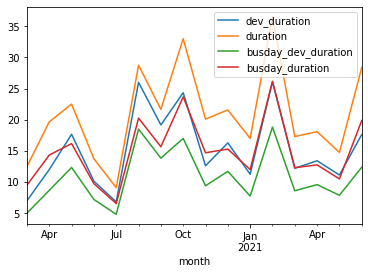

In [42]:
generate_full_duration_table_and_chart(df1, 'month')

# Duration Time without extremes

In [43]:
df2 = df.copy()
df2 = calculate_estimatives_by_duration_column(df2, 'duration', False)

,dev_duration,duration,busday_dev_duration,busday_duration
quarter,,,,
2020Q1,7.000000,12.500000,5.000000,9.500000
2020Q2,13.952381,18.952381,9.857143,13.523810
2020Q3,15.266667,18.133333,10.866667,12.933333
2020Q4,17.388889,25.000000,12.611111,18.000000
2021Q1,12.619048,18.095238,8.904762,12.857143
2021Q2,12.962963,18.333333,9.185185,12.925926


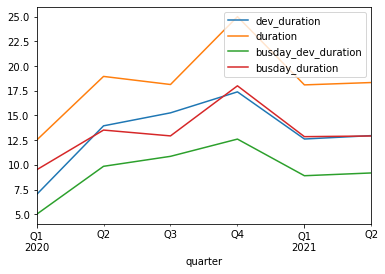

In [44]:
generate_full_duration_table_and_chart(df2, 'quarter')

,dev_duration,duration,busday_dev_duration,busday_duration
month,,,,
2020-03,7.000000,12.500000,5.000000,9.500000
2020-04,12.000000,19.666667,8.666667,14.333333
2020-05,17.666667,22.500000,12.333333,16.166667
2020-06,12.583333,17.000000,8.916667,12.000000
2020-07,12.000000,15.833333,8.333333,11.166667
2020-08,14.000000,15.666667,10.000000,11.000000
2020-09,19.166667,21.666667,13.833333,15.666667
2020-10,24.333333,33.000000,17.000000,23.666667
2020-11,14.000000,22.222222,10.444444,16.222222


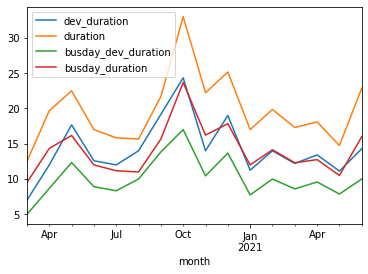

In [45]:
generate_full_duration_table_and_chart(df2, 'month')

# Amount delivered by month

<AxesSubplot:xlabel='month'>

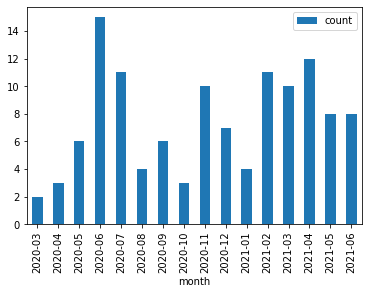

In [46]:
df[['month', 'count']].groupby('month').sum('count').plot(kind='bar')

<AxesSubplot:xlabel='month'>

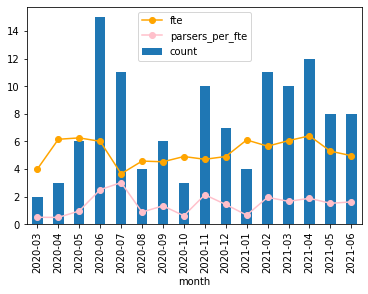

In [47]:
by_month = df[['month', 'count']].groupby('month').sum('count')

monthly_result = pd.merge(by_month, total_fte, on='month', how='left')

monthly_result['parsers_per_fte'] = monthly_result['count'].div(monthly_result['fte'])

monthly_result['month'] = monthly_result['month'].astype(str)

ax = monthly_result[['month','fte', 'parsers_per_fte']].plot(x='month', linestyle='-', marker='o', color=['orange', 'pink'])
monthly_result[['month','count']].plot(x='month', kind='bar', ax=ax)

In [48]:
monthly_result

,month,count,fte,quarter,parsers_per_fte
0,2020-03,2,4.00,2020Q1,0.500000
1,2020-04,3,6.15,2020Q2,0.487805
2,2020-05,6,6.25,2020Q2,0.960000
3,2020-06,15,6.00,2020Q2,2.500000
4,2020-07,11,3.65,2020Q3,3.013699
5,2020-08,4,4.57,2020Q3,0.875274
6,2020-09,6,4.52,2020Q3,1.327434
7,2020-10,3,4.90,2020Q4,0.612245
8,2020-11,10,4.70,2020Q4,2.127660
9,2020-12,7,4.90,2020Q4,1.428571


# Amount delivered by quarter

<AxesSubplot:xlabel='quarter'>

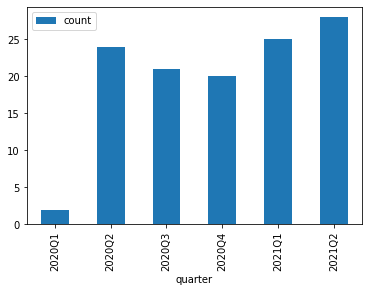

In [49]:
df[['quarter', 'count']].groupby('quarter').sum('count').plot(kind='bar')

<AxesSubplot:xlabel='quarter'>

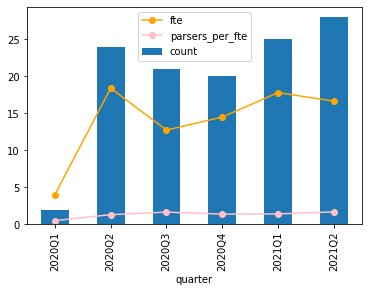

In [50]:
by_quarter = df[['quarter', 'count']].groupby('quarter').sum('count')

by_quarter_fte = pd.merge(by_quarter, total_fte, on='quarter', how='left')

quartly_result = by_quarter_fte[['quarter', 'count', 'fte']].groupby(['quarter','count']).sum('fte')
quartly_result.reset_index(drop=False, inplace=True)

quartly_result['parsers_per_fte'] = quartly_result['count'].div(quartly_result['fte'])


quartly_result['quarter'] = quartly_result['quarter'].astype(str)

ax = quartly_result[['quarter','fte', 'parsers_per_fte']].plot(x='quarter', linestyle='-', marker='o', color=['orange', 'pink'])
quartly_result[['quarter','count']].plot(x='quarter', kind='bar', ax=ax)

In [51]:
quartly_result

,quarter,count,fte,parsers_per_fte
0,2020Q1,2,4.00,0.500000
1,2020Q2,24,18.40,1.304348
2,2020Q3,21,12.74,1.648352
3,2020Q4,20,14.50,1.379310
4,2021Q1,25,17.80,1.404494
5,2021Q2,28,16.65,1.681682


# Data for business days

,busday_duration
quarter,
2020Q1,9.500000
2020Q2,14.200000
2020Q3,12.933333
2020Q4,18.000000
2021Q1,12.857143
2021Q2,12.925926


,count
quarter,
2020Q1,2
2020Q2,20
2020Q3,15
2020Q4,18
2021Q1,21
2021Q2,27


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,11
2020-07,6
2020-08,3
2020-09,6
2020-10,3
2020-11,9


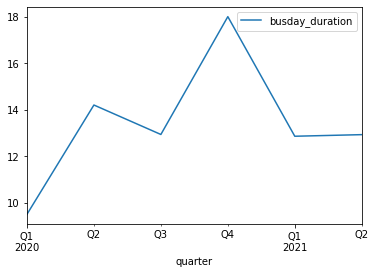

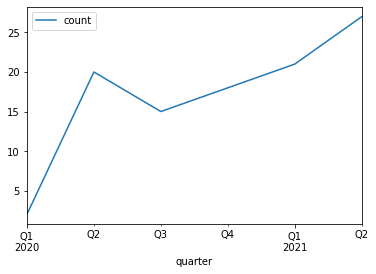

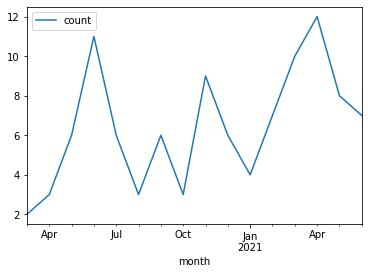

In [52]:
generate_tables_and_charts_by_duration_colum(df, 'busday_duration', True)

,busday_duration
quarter,
2020Q1,9.500000
2020Q2,11.916667
2020Q3,11.761905
2020Q4,16.250000
2021Q1,18.360000
2021Q2,14.142857


,count
quarter,
2020Q1,2
2020Q2,24
2020Q3,21
2020Q4,20
2021Q1,25
2021Q2,28


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,15
2020-07,11
2020-08,4
2020-09,6
2020-10,3
2020-11,10


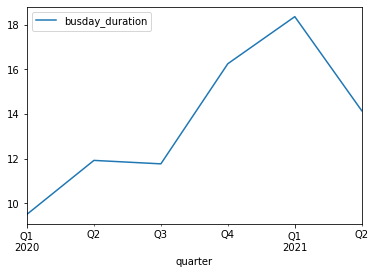

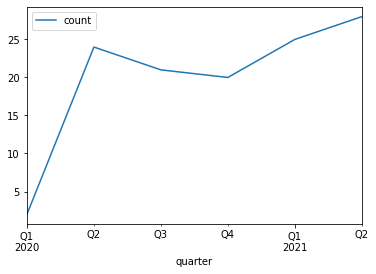

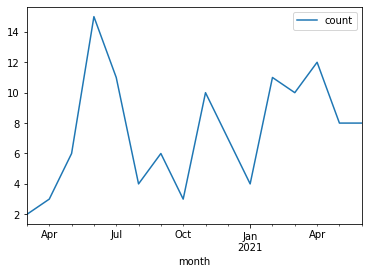

In [53]:
generate_tables_and_charts_by_duration_colum(df, 'busday_duration', False)

# Data for duration days

,duration
quarter,
2020Q1,12.500000
2020Q2,18.952381
2020Q3,18.133333
2020Q4,25.000000
2021Q1,18.095238
2021Q2,18.333333


,count
quarter,
2020Q1,2
2020Q2,21
2020Q3,15
2020Q4,18
2021Q1,21
2021Q2,27


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,12
2020-07,6
2020-08,3
2020-09,6
2020-10,3
2020-11,9


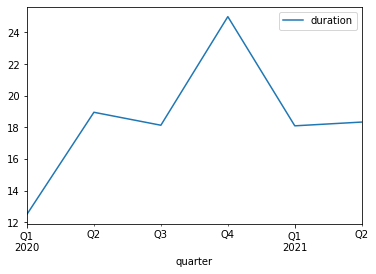

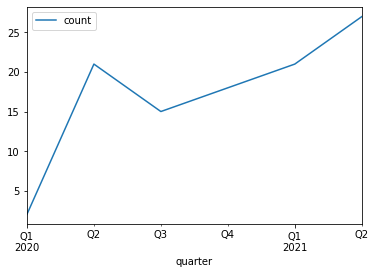

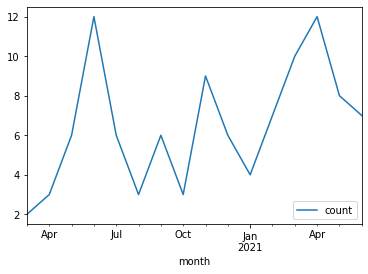

In [54]:
generate_tables_and_charts_by_duration_colum(df, 'duration', True)

,duration
quarter,
2020Q1,12.500000
2020Q2,18.952381
2020Q3,18.133333
2020Q4,25.000000
2021Q1,18.095238
2021Q2,18.333333


,count
quarter,
2020Q1,2
2020Q2,21
2020Q3,15
2020Q4,18
2021Q1,21
2021Q2,27


,count
month,
2020-03,2
2020-04,3
2020-05,6
2020-06,12
2020-07,6
2020-08,3
2020-09,6
2020-10,3
2020-11,9


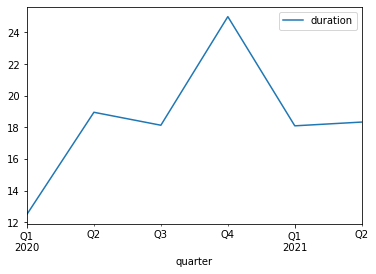

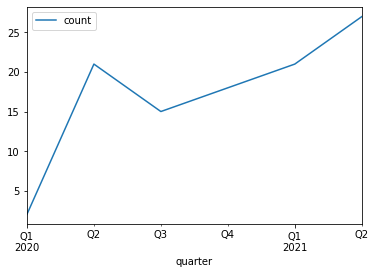

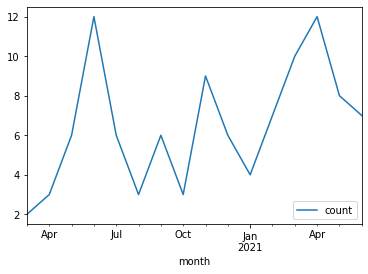

In [55]:
generate_tables_and_charts_by_duration_colum(df, 'duration', True)